In [3]:
import sys
import os
"""Import the basics; numpy, pandas, matplotlib et al."""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

We first implement the Mass-Metallicity relation using Eq. (5) from Zahid et al. (2014)

![image](mz_relation.png 'MZ Relation')

In [4]:
def zahid_mz_relation(mass_arr, Z0, M0, gamma):
    
    """
    :param Z0: The saturation metallicity.
    :param M0: The characteristic turnover mass above which the metallicity asymptotically
               approaches the upper metallicity limit, Z0.
    :param gamma: At stellar masses < M0, the MZ relation reduces to a power law with an index gamma
    """
    
    Z = Z0 + np.log10(1.0 - np.exp(-1*(mass_arr / M0)**gamma))
    
    return Z

In [5]:
"""Test for a linear uniform stellar mass range"""

m_star_arr = np.arange(start=10**8, stop=10**11, step=10**7)

"""Choosing a set of values (COSMOS) from the paper for the constants in the function"""
Z0_ = 9.08
M0_ = 10**10.06
gamma_ = 0.61

Z_ = zahid_mz_relation(m_star_arr, Z0_, M0_, gamma_)

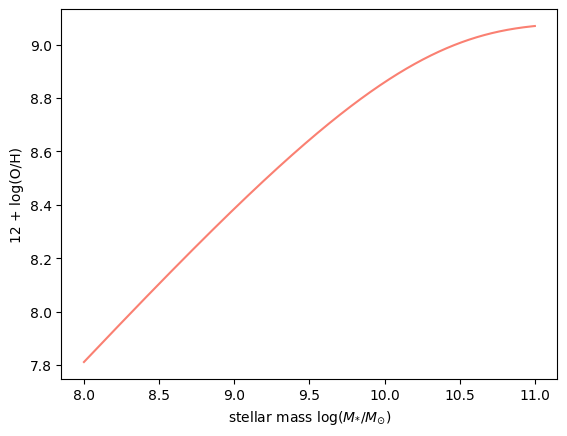

In [6]:
plt.plot(np.log10(m_star_arr), Z_, color='salmon')
plt.ylabel('12 + log(O/H)')
plt.xlabel('stellar mass log($M_{*} / M_{\odot}$)')
plt.show()